<a href="https://colab.research.google.com/github/CalvinXKY/mfu_calculation/blob/main/MLA_absorb_mfu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLA运算非吸收矩阵与吸收矩阵的运算量对比：

知乎@kaiyuan

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# MLA的相关参数，参考DeepSeekV3参数
bs = 1
heads = 128
qk_head_dim = 128
kv_lora_rank = 512
h_dim = 7168
q_lora_rank = 1536
qk_rope_head_dim = 64
v_head_dim = 128
n_heads = v_head_dim


In [ ]:

# 非吸收矩阵计算:
def calc_mla_non_absorb_flops(seq_len, cache_len=0):
    q_down_proj = 2 * bs * seq_len * h_dim * q_lora_rank
    q_up_proj = 2 * bs * seq_len * q_lora_rank * heads * (qk_head_dim + qk_rope_head_dim)
    q_linear = q_down_proj + q_up_proj

    kv_down_proj = 2 * bs * seq_len * h_dim * (kv_lora_rank + qk_rope_head_dim)
    kv_up_proj = 2 * bs * heads * (seq_len + cache_len) * kv_lora_rank * (qk_head_dim + v_head_dim)
    kv_linear = kv_down_proj + kv_up_proj

    kv_scores = 2 * bs * heads * seq_len * (seq_len + cache_len) * (qk_head_dim + qk_rope_head_dim)
    qkv = 2 * bs * heads * seq_len * (seq_len + cache_len) * v_head_dim
    out = 2 * bs * seq_len * n_heads * v_head_dim * h_dim
    attention = kv_scores + qkv
    mla_non_absorb_flops = attention + kv_linear + q_linear + out
    return mla_non_absorb_flops, q_linear, kv_linear, attention, out


# 吸收矩阵计算:
def calc_mla_absorb_flops(seq_len, cache_len=0):
    q_down_proj = 2 * bs * seq_len * h_dim * q_lora_rank
    q_up_proj = 2 * bs * seq_len * q_lora_rank * heads * (qk_head_dim + qk_rope_head_dim)
    q_absorb = 2 * bs * heads * seq_len * qk_head_dim * kv_lora_rank

    q_linear = q_down_proj + q_up_proj + q_absorb

    kv_down_proj = 2 * bs * seq_len * h_dim * (kv_lora_rank + qk_rope_head_dim)
    kv_linear = kv_down_proj

    kv_scores = 2 * bs * heads * seq_len * (seq_len + cache_len) * (kv_lora_rank + qk_rope_head_dim)
    qkv = 2 * bs * heads * seq_len * (seq_len + cache_len) * kv_lora_rank
    out_absorb = 2 * bs * seq_len * heads * kv_lora_rank * v_head_dim
    out = 2 * bs * seq_len * n_heads * v_head_dim * h_dim + out_absorb
    attention = kv_scores + qkv
    mla_absorb_flops = attention + kv_linear + q_linear + out

    return mla_absorb_flops, q_linear, kv_linear, attention, out


def convert_flops(flops, cof=1024 * 1024 * 1024):
    return flops / cof


# 打印函数：
def print_data(str_name, non_absorb, absorb, unit="TFlops"""):
    print(f"{str_name}非吸收矩阵{convert_flops(non_absorb)} {unit} 吸收矩阵{convert_flops(absorb)} {unit} "
          f"差值：{convert_flops(non_absorb) - convert_flops(absorb)} {unit}")

# 绘制曲线
def plot_data(seq_len=0, cache_len=0, x_lab="seq_len"):
    x_values = []
    y_values = []
    for change_len in range(0, 100, 10):
        x_values.append(change_len)
        if x_lab == "seq_len":
          seq_len = change_len
        else:
          cache_len = change_len
        y_values.append(convert_flops(calc_mla_non_absorb_flops(seq_len, cache_len)[0] - calc_mla_absorb_flops(seq_len, cache_len)[0]))


    plt.figure(figsize=(10, 6))
    plt.plot(x_values, y_values, marker='o', linestyle='-', color='b', linewidth=2)
    if x_lab == "seq_len":
      plt.title(f"cache_seq={cache_len}", fontsize=14)
      plt.xlabel("seq_len", fontsize=12)
    else:
      plt.title(f"seq_len={seq_len}", fontsize=14)
      plt.xlabel("cache_seq", fontsize=12)
    plt.ylabel("Diff: non-absorb - absorb Tflops", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)

    for i, (x, y) in enumerate(zip(x_values, y_values)):
        plt.annotate(f'{y:.1f}', (x, y), textcoords="offset points",
                     xytext=(0, 10), ha='center', fontsize=9)

    plt.show()


In [ ]:
# seq_len输入的tokens长度，表示cache的长度：
seq_len = 10
cache_len = 0

mla_non_absorb_flops, q_linear, kv_linear, attention, out = calc_mla_non_absorb_flops(seq_len, cache_len)
mla_absorb_flops, absorb_q_linear, absorb_kv_linear, absorb_attention, absorb_out = calc_mla_absorb_flops(seq_len,
                                                                                                          cache_len)
print_data("整体运算量", mla_non_absorb_flops, mla_absorb_flops)
print_data("q_linear", q_linear, absorb_q_linear)
print_data("kv_linear", kv_linear, absorb_kv_linear)
print_data("attention", attention, absorb_attention)
print_data("out", out, absorb_out)

整体运算量非吸收矩阵3.49273681640625 TFlops 吸收矩阵3.51104736328125 TFlops 差值：-0.018310546875 TFlops
q_linear非吸收矩阵0.908203125 TFlops 吸收矩阵1.064453125 TFlops 差值：-0.15625 TFlops
kv_linear非吸收矩阵0.389404296875 TFlops 吸收矩阵0.076904296875 TFlops 差值：0.3125 TFlops
attention非吸收矩阵0.00762939453125 TFlops 吸收矩阵0.02593994140625 TFlops 差值：-0.018310546875 TFlops
out非吸收矩阵2.1875 TFlops 吸收矩阵2.34375 TFlops 差值：-0.15625 TFlops


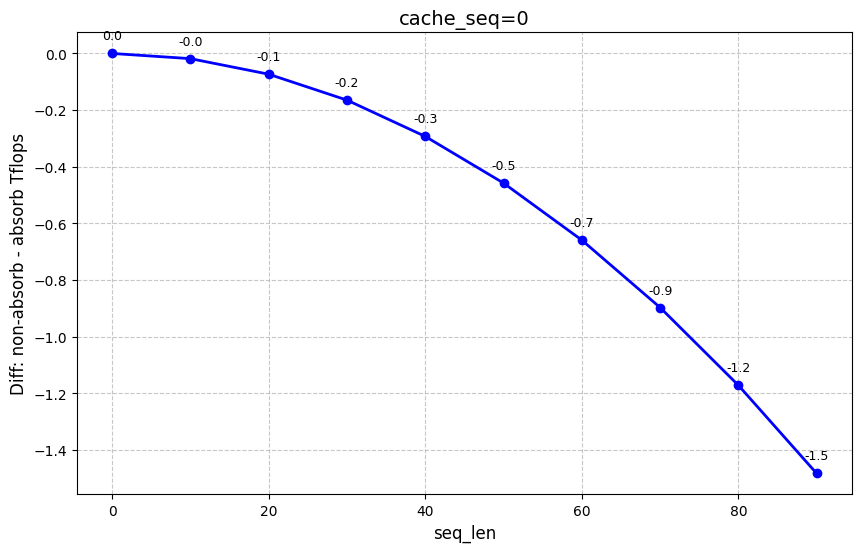

In [ ]:
# 在prefill阶段 cache=0
plot_data(cache_len=0, x_lab="seq_len")

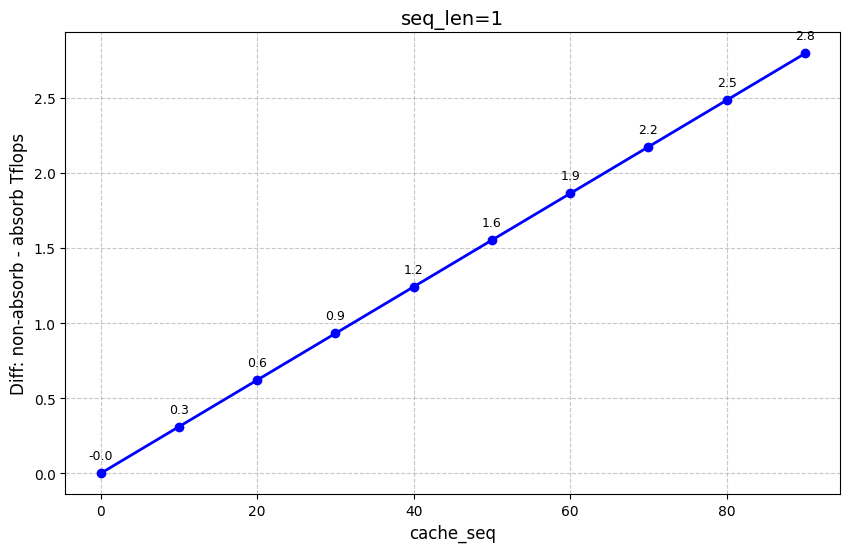

In [ ]:
# 在decode阶段seq_len=1
plot_data(seq_len=1, x_lab="cache_len")

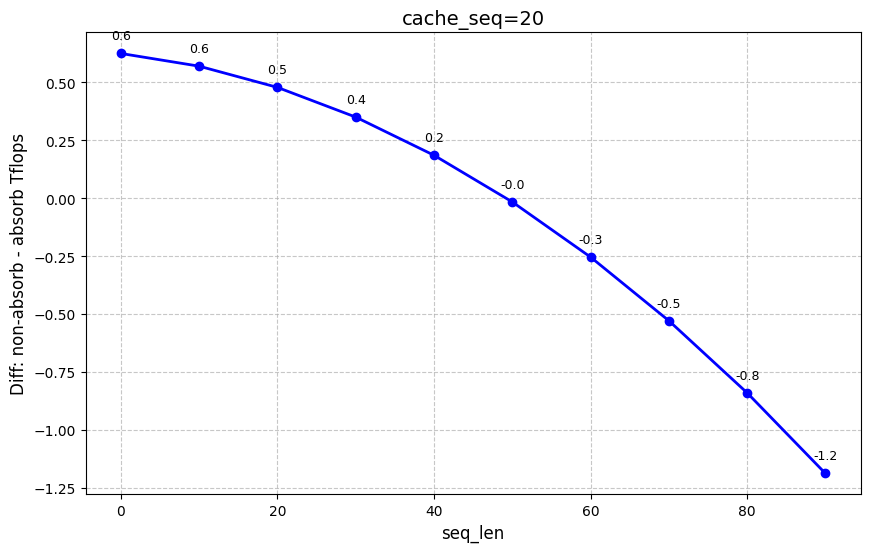

In [ ]:
# 在prefill阶段 cache=20
plot_data(cache_len=20, x_lab="seq_len")